In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import pcraster as pcr
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
# import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
# from pcrglobwb_203_30min_2way import pcrglobwb_bmi
# from pcrglobwb_203_30min_2way import disclaimer
import model as pcrglobwb_bmi_v203
from model import pcrglobwb_bmi
from model import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import utils
from coupling_PCR_FM_2way import configuration
%config Application.log_level="INFO"

/home/jannis/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

# arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'
arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment_LFP.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
    inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
    use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

couple_channelStorage = False

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [5]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr )
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])
LDD                 = os.path.join(inputDIR, configPCR.routingOptions['lddMap'])

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'

elif model_type == 'LFP':
    model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'

else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [7]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE AND SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-03-01 15:34:55,569 model.disclaimer INFO 

 PCR-GLOBWB (PCRaster Global Water Balance) Global Hydrological Model                       

 Copyright (C) 2016, Ludovicus P. H. (Rens) van Beek, Edwin H. Sutanudjaja, Yoshihide Wada, 
 Joyce H. C. Bosmans, Niels Drost, Inge E. M. de Graaf, Kor de Jong, Patricia Lopez Lopez,  
 Stefanie Pessenteiner, Oliver Schmitz, Menno W. Straatsma, Niko Wanders, Dominik Wisser,   
 and Marc F. P. Bierkens,                                                                   
 Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands                       

 This program comes with ABSOLUTELY NO WARRANTY                                             
 This is free software, and you are welcome to redistribute it under certain conditions     
 See the LICENSE file for more details                                                      


2018-03-01 15:34:55,570 model.configuration INFO Model run started at 2018-03-01 15:34:55.559318
2018-03-01 15:


##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  LFP_AMA_test2way.par
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-03-01 15:34:55.558839



2018-03-01 15:34:56,076 model.meteo INFO No forcing downscaling is implemented.
2018-03-01 15:34:56,248 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-03-01 15:34:56,250 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-03-01 15:34:56,251 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-03-01 15:34:56,253 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-03-01 15:34:56,255 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-03-01 15:34:56,263 model.landSurface INFO Monthly desalination water is NOT included.
2018-03-01 15:34:56,264 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-03-01 15:34:58,634 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa


>>> PCR Initialized <<<



2018-03-01 15:35:05,557 model.meteo INFO No forcing downscaling is implemented.
2018-03-01 15:35:05,706 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-03-01 15:35:05,708 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-03-01 15:35:05,709 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-03-01 15:35:05,710 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-03-01 15:35:05,711 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-03-01 15:35:05,717 model.landSurface INFO Monthly desalination water is NOT included.
2018-03-01 15:35:05,718 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-03-01 15:35:08,192 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa

2018-03-01 15:35:19,067 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-03-01 15:35:19,151 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-03-01 15:35:19,291 model.groundwater INFO Updating groundwater
2018-03-01 15:35:19,297 model.routing INFO routing in progress
2018-03-01 15:35:19,301 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:19,313 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:19,330 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:19,347 model.routing INFO sub-daily t

2018-03-01 15:35:21,702 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-03-01 15:35:21,778 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-03-01 15:35:21,909 model.groundwater INFO Updating groundwater
2018-03-01 15:35:21,914 model.routing INFO routing in progress
2018-03-01 15:35:21,919 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:21,931 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:21,951 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:21,972 model.routing INFO sub-daily t

2018-03-01 15:35:24,382 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-03-01 15:35:24,459 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-03-01 15:35:24,594 model.groundwater INFO Updating groundwater
2018-03-01 15:35:24,599 model.routing INFO routing in progress
2018-03-01 15:35:24,603 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:24,614 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:24,630 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:24,647 model.routing INFO sub-daily t

2018-03-01 15:35:27,003 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-03-01 15:35:27,085 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-03-01 15:35:27,224 model.groundwater INFO Updating groundwater
2018-03-01 15:35:27,231 model.routing INFO routing in progress
2018-03-01 15:35:27,236 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:27,249 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:27,270 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:27,294 model.routing INFO sub-daily t

2018-03-01 15:35:29,623 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-03-01 15:35:29,705 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-03-01 15:35:29,834 model.groundwater INFO Updating groundwater
2018-03-01 15:35:29,840 model.routing INFO routing in progress
2018-03-01 15:35:29,846 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:29,857 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:29,873 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:29,889 model.routing INFO sub-daily

2018-03-01 15:35:32,234 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-03-01 15:35:32,322 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-03-01 15:35:32,455 model.groundwater INFO Updating groundwater
2018-03-01 15:35:32,463 model.routing INFO routing in progress
2018-03-01 15:35:32,469 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:32,482 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:32,502 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:32,521 model.routing INFO sub-daily

2018-03-01 15:35:34,775 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-03-01 15:35:34,858 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-03-01 15:35:35,020 model.groundwater INFO Updating groundwater
2018-03-01 15:35:35,027 model.routing INFO routing in progress
2018-03-01 15:35:35,032 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:35,044 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:35,068 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:35,087 model.routing INFO sub-daily

2018-03-01 15:35:37,407 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-03-01 15:35:37,486 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-03-01 15:35:37,614 model.groundwater INFO Updating groundwater
2018-03-01 15:35:37,620 model.routing INFO routing in progress
2018-03-01 15:35:37,623 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:37,634 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:37,650 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:37,670 model.routing INFO sub-daily

2018-03-01 15:35:40,022 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-03-01 15:35:40,094 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-03-01 15:35:40,221 model.groundwater INFO Updating groundwater
2018-03-01 15:35:40,228 model.routing INFO routing in progress
2018-03-01 15:35:40,233 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:40,246 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:40,265 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:40,283 model.routing INFO sub-daily

2018-03-01 15:35:42,625 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-03-01 15:35:42,701 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-03-01 15:35:42,834 model.groundwater INFO Updating groundwater
2018-03-01 15:35:42,842 model.routing INFO routing in progress
2018-03-01 15:35:42,847 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:42,860 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:42,879 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:42,896 model.routing INFO sub-daily

2018-03-01 15:35:45,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-03-01 15:35:45,225 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-03-01 15:35:45,367 model.groundwater INFO Updating groundwater
2018-03-01 15:35:45,373 model.routing INFO routing in progress
2018-03-01 15:35:45,376 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:45,387 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:45,404 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:45,421 model.routing INFO sub-daily

2018-03-01 15:35:47,692 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-03-01 15:35:47,766 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-03-01 15:35:47,907 model.groundwater INFO Updating groundwater
2018-03-01 15:35:47,912 model.routing INFO routing in progress
2018-03-01 15:35:47,916 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:47,927 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:47,942 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:47,957 model.routing INFO sub-daily

2018-03-01 15:35:50,244 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-03-01 15:35:50,319 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-03-01 15:35:50,459 model.groundwater INFO Updating groundwater
2018-03-01 15:35:50,465 model.routing INFO routing in progress
2018-03-01 15:35:50,468 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:50,486 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:50,512 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:50,541 model.routing INFO sub-daily

2018-03-01 15:35:52,875 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-03-01 15:35:52,976 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-03-01 15:35:53,119 model.groundwater INFO Updating groundwater
2018-03-01 15:35:53,124 model.routing INFO routing in progress
2018-03-01 15:35:53,127 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:53,140 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:53,154 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:53,170 model.routing INFO sub-daily

2018-03-01 15:35:55,512 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-03-01 15:35:55,602 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-03-01 15:35:55,740 model.groundwater INFO Updating groundwater
2018-03-01 15:35:55,746 model.routing INFO routing in progress
2018-03-01 15:35:55,749 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:55,760 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:55,777 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:55,794 model.routing INFO sub-daily

2018-03-01 15:35:58,059 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-03-01 15:35:58,133 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-03-01 15:35:58,262 model.groundwater INFO Updating groundwater
2018-03-01 15:35:58,271 model.routing INFO routing in progress
2018-03-01 15:35:58,276 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:35:58,290 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:35:58,385 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:35:58,483 model.routing INFO sub-daily t

2018-03-01 15:36:02,522 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-03-01 15:36:02,604 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-03-01 15:36:02,739 model.groundwater INFO Updating groundwater
2018-03-01 15:36:02,748 model.routing INFO routing in progress
2018-03-01 15:36:02,754 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:02,767 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:02,787 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:02,807 model.routing INFO sub-daily t

2018-03-01 15:36:05,155 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-03-01 15:36:05,247 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-03-01 15:36:05,384 model.groundwater INFO Updating groundwater
2018-03-01 15:36:05,393 model.routing INFO routing in progress
2018-03-01 15:36:05,399 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:05,412 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:05,431 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:05,450 model.routing INFO sub-daily t

2018-03-01 15:36:07,711 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-03-01 15:36:07,785 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-03-01 15:36:07,909 model.groundwater INFO Updating groundwater
2018-03-01 15:36:07,915 model.routing INFO routing in progress
2018-03-01 15:36:07,920 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:07,933 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:07,952 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:07,970 model.routing INFO sub-daily t

2018-03-01 15:36:10,390 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-03-01 15:36:10,472 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-03-01 15:36:10,601 model.groundwater INFO Updating groundwater
2018-03-01 15:36:10,620 model.routing INFO routing in progress
2018-03-01 15:36:10,626 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:10,638 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:10,656 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:10,674 model.routing INFO sub-daily t

2018-03-01 15:36:13,115 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-03-01 15:36:13,190 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-03-01 15:36:13,343 model.groundwater INFO Updating groundwater
2018-03-01 15:36:13,349 model.routing INFO routing in progress
2018-03-01 15:36:13,353 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:13,364 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:13,381 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:13,398 model.routing INFO sub-daily

2018-03-01 15:36:15,666 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-03-01 15:36:15,745 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-03-01 15:36:15,889 model.groundwater INFO Updating groundwater
2018-03-01 15:36:15,894 model.routing INFO routing in progress
2018-03-01 15:36:15,897 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:15,908 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:15,927 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:15,943 model.routing INFO sub-daily

2018-03-01 15:36:18,242 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-03-01 15:36:18,348 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-03-01 15:36:18,486 model.groundwater INFO Updating groundwater
2018-03-01 15:36:18,493 model.routing INFO routing in progress
2018-03-01 15:36:18,500 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:18,513 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:18,534 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:18,553 model.routing INFO sub-daily

2018-03-01 15:36:20,904 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-03-01 15:36:20,995 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-03-01 15:36:21,133 model.groundwater INFO Updating groundwater
2018-03-01 15:36:21,139 model.routing INFO routing in progress
2018-03-01 15:36:21,150 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:21,165 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:21,185 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:21,204 model.routing INFO sub-daily

2018-03-01 15:36:23,669 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-03-01 15:36:23,746 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-03-01 15:36:23,883 model.groundwater INFO Updating groundwater
2018-03-01 15:36:23,888 model.routing INFO routing in progress
2018-03-01 15:36:23,891 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:23,901 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:23,917 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:23,933 model.routing INFO sub-daily

2018-03-01 15:36:26,263 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-03-01 15:36:26,346 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-03-01 15:36:26,493 model.groundwater INFO Updating groundwater
2018-03-01 15:36:26,500 model.routing INFO routing in progress
2018-03-01 15:36:26,506 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:26,519 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:26,538 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:26,557 model.routing INFO sub-daily

2018-03-01 15:36:28,916 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-03-01 15:36:28,990 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-03-01 15:36:29,118 model.groundwater INFO Updating groundwater
2018-03-01 15:36:29,124 model.routing INFO routing in progress
2018-03-01 15:36:29,127 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:29,138 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:29,154 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:29,171 model.routing INFO sub-daily

2018-03-01 15:36:31,527 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-03-01 15:36:31,614 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-03-01 15:36:31,749 model.groundwater INFO Updating groundwater
2018-03-01 15:36:31,756 model.routing INFO routing in progress
2018-03-01 15:36:31,761 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:31,773 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:31,791 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:31,808 model.routing INFO sub-daily

2018-03-01 15:36:34,057 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-03-01 15:36:34,150 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-03-01 15:36:34,299 model.groundwater INFO Updating groundwater
2018-03-01 15:36:34,307 model.routing INFO routing in progress
2018-03-01 15:36:34,312 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:34,334 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:34,362 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:34,380 model.routing INFO sub-daily

2018-03-01 15:36:36,967 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-03-01 15:36:37,057 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-03-01 15:36:37,203 model.groundwater INFO Updating groundwater
2018-03-01 15:36:37,211 model.routing INFO routing in progress
2018-03-01 15:36:37,216 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:37,229 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:37,249 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:37,269 model.routing INFO sub-daily

2018-03-01 15:36:41,483 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-03-01 15:36:41,562 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-03-01 15:36:41,704 model.groundwater INFO Updating groundwater
2018-03-01 15:36:41,713 model.routing INFO routing in progress
2018-03-01 15:36:41,716 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:41,727 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:41,744 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:41,761 model.routing INFO sub-daily t

2018-03-01 15:36:44,070 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-03-01 15:36:44,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-03-01 15:36:44,273 model.groundwater INFO Updating groundwater
2018-03-01 15:36:44,278 model.routing INFO routing in progress
2018-03-01 15:36:44,281 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:44,292 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:44,309 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:44,325 model.routing INFO sub-daily t

2018-03-01 15:36:46,570 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-03-01 15:36:46,647 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-03-01 15:36:46,781 model.groundwater INFO Updating groundwater
2018-03-01 15:36:46,787 model.routing INFO routing in progress
2018-03-01 15:36:46,790 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:46,801 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:46,819 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:46,836 model.routing INFO sub-daily t

2018-03-01 15:36:49,196 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-03-01 15:36:49,286 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-03-01 15:36:49,415 model.groundwater INFO Updating groundwater
2018-03-01 15:36:49,420 model.routing INFO routing in progress
2018-03-01 15:36:49,424 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:49,434 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:49,451 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:49,467 model.routing INFO sub-daily t

2018-03-01 15:36:51,913 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-03-01 15:36:51,996 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-03-01 15:36:52,140 model.groundwater INFO Updating groundwater
2018-03-01 15:36:52,145 model.routing INFO routing in progress
2018-03-01 15:36:52,149 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:52,161 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:52,179 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:52,196 model.routing INFO sub-daily

2018-03-01 15:36:54,479 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-03-01 15:36:54,561 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-03-01 15:36:54,691 model.groundwater INFO Updating groundwater
2018-03-01 15:36:54,698 model.routing INFO routing in progress
2018-03-01 15:36:54,703 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:54,716 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:54,738 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:54,756 model.routing INFO sub-daily

2018-03-01 15:36:57,129 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-03-01 15:36:57,206 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-03-01 15:36:57,374 model.groundwater INFO Updating groundwater
2018-03-01 15:36:57,384 model.routing INFO routing in progress
2018-03-01 15:36:57,391 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:36:57,404 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:36:57,425 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:36:57,444 model.routing INFO sub-daily

2018-03-01 15:36:59,961 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-03-01 15:37:00,057 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-03-01 15:37:00,195 model.groundwater INFO Updating groundwater
2018-03-01 15:37:00,202 model.routing INFO routing in progress
2018-03-01 15:37:00,207 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:00,220 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:00,233 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:00,249 model.routing INFO sub-daily

2018-03-01 15:37:02,424 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-03-01 15:37:02,497 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-03-01 15:37:02,622 model.groundwater INFO Updating groundwater
2018-03-01 15:37:02,628 model.routing INFO routing in progress
2018-03-01 15:37:02,632 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:02,643 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:02,661 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:02,678 model.routing INFO sub-daily

2018-03-01 15:37:05,010 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-03-01 15:37:05,095 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-03-01 15:37:05,234 model.groundwater INFO Updating groundwater
2018-03-01 15:37:05,242 model.routing INFO routing in progress
2018-03-01 15:37:05,248 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:05,261 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:05,281 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:05,299 model.routing INFO sub-daily

2018-03-01 15:37:07,710 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-03-01 15:37:07,784 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-03-01 15:37:07,910 model.groundwater INFO Updating groundwater
2018-03-01 15:37:07,919 model.routing INFO routing in progress
2018-03-01 15:37:07,923 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:07,935 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:07,953 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:07,972 model.routing INFO sub-daily

2018-03-01 15:37:10,333 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-03-01 15:37:10,415 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-03-01 15:37:10,558 model.groundwater INFO Updating groundwater
2018-03-01 15:37:10,564 model.routing INFO routing in progress
2018-03-01 15:37:10,567 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:10,580 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:10,598 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:10,615 model.routing INFO sub-daily

2018-03-01 15:37:13,052 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-03-01 15:37:13,133 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-03-01 15:37:13,279 model.groundwater INFO Updating groundwater
2018-03-01 15:37:13,287 model.routing INFO routing in progress
2018-03-01 15:37:13,295 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:13,319 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:13,340 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:13,359 model.routing INFO sub-daily

2018-03-01 15:37:15,713 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-03-01 15:37:15,804 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-03-01 15:37:15,947 model.groundwater INFO Updating groundwater
2018-03-01 15:37:15,953 model.routing INFO routing in progress
2018-03-01 15:37:15,957 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:15,968 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:15,984 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:16,000 model.routing INFO sub-daily

2018-03-01 15:37:18,439 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-03-01 15:37:18,511 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-03-01 15:37:18,647 model.groundwater INFO Updating groundwater
2018-03-01 15:37:18,653 model.routing INFO routing in progress
2018-03-01 15:37:18,657 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:18,667 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:18,684 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:18,704 model.routing INFO sub-daily

2018-03-01 15:37:21,021 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-03-01 15:37:21,098 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-03-01 15:37:21,235 model.groundwater INFO Updating groundwater
2018-03-01 15:37:21,249 model.routing INFO routing in progress
2018-03-01 15:37:21,253 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:21,265 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:21,369 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:21,473 model.routing INFO sub-daily t

2018-03-01 15:37:25,643 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-03-01 15:37:25,734 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-03-01 15:37:25,868 model.groundwater INFO Updating groundwater
2018-03-01 15:37:25,875 model.routing INFO routing in progress
2018-03-01 15:37:25,878 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:25,889 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:25,905 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:25,926 model.routing INFO sub-daily t

2018-03-01 15:37:28,300 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-03-01 15:37:28,375 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-03-01 15:37:28,517 model.groundwater INFO Updating groundwater
2018-03-01 15:37:28,526 model.routing INFO routing in progress
2018-03-01 15:37:28,533 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:28,546 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:28,568 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:28,589 model.routing INFO sub-daily t

2018-03-01 15:37:30,971 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-03-01 15:37:31,044 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-03-01 15:37:31,171 model.groundwater INFO Updating groundwater
2018-03-01 15:37:31,178 model.routing INFO routing in progress
2018-03-01 15:37:31,183 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:31,197 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:31,222 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:31,245 model.routing INFO sub-daily t

2018-03-01 15:37:33,576 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-03-01 15:37:33,654 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-03-01 15:37:33,786 model.groundwater INFO Updating groundwater
2018-03-01 15:37:33,792 model.routing INFO routing in progress
2018-03-01 15:37:33,796 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:33,807 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:33,823 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:33,840 model.routing INFO sub-daily t

2018-03-01 15:37:36,221 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-03-01 15:37:36,303 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-03-01 15:37:36,438 model.groundwater INFO Updating groundwater
2018-03-01 15:37:36,444 model.routing INFO routing in progress
2018-03-01 15:37:36,447 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:36,458 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:36,475 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:36,490 model.routing INFO sub-daily

2018-03-01 15:37:38,787 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-03-01 15:37:38,877 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-03-01 15:37:39,023 model.groundwater INFO Updating groundwater
2018-03-01 15:37:39,029 model.routing INFO routing in progress
2018-03-01 15:37:39,035 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:39,048 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:39,069 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:39,090 model.routing INFO sub-daily

2018-03-01 15:37:41,468 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-03-01 15:37:41,542 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-03-01 15:37:41,679 model.groundwater INFO Updating groundwater
2018-03-01 15:37:41,685 model.routing INFO routing in progress
2018-03-01 15:37:41,689 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:41,701 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:41,718 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:41,735 model.routing INFO sub-daily

2018-03-01 15:37:44,015 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-03-01 15:37:44,099 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-03-01 15:37:44,239 model.groundwater INFO Updating groundwater
2018-03-01 15:37:44,246 model.routing INFO routing in progress
2018-03-01 15:37:44,252 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:44,264 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:44,283 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:44,305 model.routing INFO sub-daily

2018-03-01 15:37:46,684 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-03-01 15:37:46,760 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-03-01 15:37:46,892 model.groundwater INFO Updating groundwater
2018-03-01 15:37:46,900 model.routing INFO routing in progress
2018-03-01 15:37:46,907 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:46,920 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:46,941 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:46,959 model.routing INFO sub-daily

2018-03-01 15:37:49,241 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-03-01 15:37:49,318 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-03-01 15:37:49,470 model.groundwater INFO Updating groundwater
2018-03-01 15:37:49,479 model.routing INFO routing in progress
2018-03-01 15:37:49,485 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:49,509 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:49,531 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:49,550 model.routing INFO sub-daily

2018-03-01 15:37:51,950 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-03-01 15:37:52,023 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-03-01 15:37:52,164 model.groundwater INFO Updating groundwater
2018-03-01 15:37:52,170 model.routing INFO routing in progress
2018-03-01 15:37:52,174 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:52,186 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:52,205 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:52,223 model.routing INFO sub-daily

2018-03-01 15:37:54,572 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-03-01 15:37:54,668 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-03-01 15:37:54,812 model.groundwater INFO Updating groundwater
2018-03-01 15:37:54,818 model.routing INFO routing in progress
2018-03-01 15:37:54,821 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:54,832 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:54,851 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:54,868 model.routing INFO sub-daily

2018-03-01 15:37:57,259 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-03-01 15:37:57,346 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-03-01 15:37:57,484 model.groundwater INFO Updating groundwater
2018-03-01 15:37:57,490 model.routing INFO routing in progress
2018-03-01 15:37:57,493 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:57,503 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:37:57,521 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:37:57,538 model.routing INFO sub-daily

2018-03-01 15:37:59,763 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-03-01 15:37:59,836 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-03-01 15:37:59,966 model.groundwater INFO Updating groundwater
2018-03-01 15:37:59,973 model.routing INFO routing in progress
2018-03-01 15:37:59,978 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:37:59,990 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:00,008 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:00,026 model.routing INFO sub-daily

2018-03-01 15:38:02,445 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-03-01 15:38:02,525 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-03-01 15:38:02,671 model.groundwater INFO Updating groundwater
2018-03-01 15:38:02,677 model.routing INFO routing in progress
2018-03-01 15:38:02,680 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:02,691 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:02,785 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:02,879 model.routing INFO sub-daily t

2018-03-01 15:38:06,921 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-03-01 15:38:07,000 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-03-01 15:38:07,137 model.groundwater INFO Updating groundwater
2018-03-01 15:38:07,145 model.routing INFO routing in progress
2018-03-01 15:38:07,150 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:07,163 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:07,181 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:07,199 model.routing INFO sub-daily t

2018-03-01 15:38:09,432 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-03-01 15:38:09,503 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-03-01 15:38:09,634 model.groundwater INFO Updating groundwater
2018-03-01 15:38:09,639 model.routing INFO routing in progress
2018-03-01 15:38:09,643 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:09,654 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:09,671 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:09,688 model.routing INFO sub-daily t

2018-03-01 15:38:11,982 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-03-01 15:38:12,074 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-03-01 15:38:12,212 model.groundwater INFO Updating groundwater
2018-03-01 15:38:12,218 model.routing INFO routing in progress
2018-03-01 15:38:12,221 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:12,232 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:12,249 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:12,265 model.routing INFO sub-daily t

2018-03-01 15:38:14,766 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-03-01 15:38:14,847 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-03-01 15:38:15,007 model.groundwater INFO Updating groundwater
2018-03-01 15:38:15,013 model.routing INFO routing in progress
2018-03-01 15:38:15,016 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:15,027 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:15,044 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:15,061 model.routing INFO sub-daily t

2018-03-01 15:38:17,413 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-03-01 15:38:17,495 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-03-01 15:38:17,630 model.groundwater INFO Updating groundwater
2018-03-01 15:38:17,635 model.routing INFO routing in progress
2018-03-01 15:38:17,640 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:17,653 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:17,671 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:17,689 model.routing INFO sub-daily

2018-03-01 15:38:19,998 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-03-01 15:38:20,081 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-03-01 15:38:20,222 model.groundwater INFO Updating groundwater
2018-03-01 15:38:20,231 model.routing INFO routing in progress
2018-03-01 15:38:20,237 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:20,251 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:20,270 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:20,288 model.routing INFO sub-daily

2018-03-01 15:38:22,669 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-03-01 15:38:22,752 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-03-01 15:38:22,901 model.groundwater INFO Updating groundwater
2018-03-01 15:38:22,907 model.routing INFO routing in progress
2018-03-01 15:38:22,909 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:22,920 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:22,936 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:22,952 model.routing INFO sub-daily

2018-03-01 15:38:25,436 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-03-01 15:38:25,515 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-03-01 15:38:25,656 model.groundwater INFO Updating groundwater
2018-03-01 15:38:25,662 model.routing INFO routing in progress
2018-03-01 15:38:25,665 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:25,676 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:25,694 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:25,712 model.routing INFO sub-daily

2018-03-01 15:38:28,061 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-03-01 15:38:28,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-03-01 15:38:28,289 model.groundwater INFO Updating groundwater
2018-03-01 15:38:28,297 model.routing INFO routing in progress
2018-03-01 15:38:28,303 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:28,317 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:28,337 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:28,357 model.routing INFO sub-daily

2018-03-01 15:38:30,804 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-03-01 15:38:30,880 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-03-01 15:38:31,012 model.groundwater INFO Updating groundwater
2018-03-01 15:38:31,018 model.routing INFO routing in progress
2018-03-01 15:38:31,021 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:31,031 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:31,048 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:31,064 model.routing INFO sub-daily

2018-03-01 15:38:33,361 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-03-01 15:38:33,441 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-03-01 15:38:33,575 model.groundwater INFO Updating groundwater
2018-03-01 15:38:33,581 model.routing INFO routing in progress
2018-03-01 15:38:33,584 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:33,594 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:33,611 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:33,627 model.routing INFO sub-daily

2018-03-01 15:38:35,957 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-03-01 15:38:36,053 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-03-01 15:38:36,220 model.groundwater INFO Updating groundwater
2018-03-01 15:38:36,233 model.routing INFO routing in progress
2018-03-01 15:38:36,236 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:36,246 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:36,263 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:36,280 model.routing INFO sub-daily

2018-03-01 15:38:38,592 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-03-01 15:38:38,669 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-03-01 15:38:38,811 model.groundwater INFO Updating groundwater
2018-03-01 15:38:38,816 model.routing INFO routing in progress
2018-03-01 15:38:38,820 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:38,831 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:38,849 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:38,866 model.routing INFO sub-daily

2018-03-01 15:38:41,220 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-03-01 15:38:41,310 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-03-01 15:38:41,461 model.groundwater INFO Updating groundwater
2018-03-01 15:38:41,467 model.routing INFO routing in progress
2018-03-01 15:38:41,471 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:41,482 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:41,500 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:41,518 model.routing INFO sub-daily

2018-03-01 15:38:43,941 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-03-01 15:38:44,023 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-03-01 15:38:44,162 model.groundwater INFO Updating groundwater
2018-03-01 15:38:44,172 model.routing INFO routing in progress
2018-03-01 15:38:44,177 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:44,190 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:44,211 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:44,231 model.routing INFO sub-daily

2018-03-01 15:38:48,388 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-03-01 15:38:48,463 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-03-01 15:38:48,593 model.groundwater INFO Updating groundwater
2018-03-01 15:38:48,599 model.routing INFO routing in progress
2018-03-01 15:38:48,602 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:48,612 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:48,629 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:48,645 model.routing INFO sub-daily t

2018-03-01 15:38:50,996 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-03-01 15:38:51,071 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-03-01 15:38:51,201 model.groundwater INFO Updating groundwater
2018-03-01 15:38:51,206 model.routing INFO routing in progress
2018-03-01 15:38:51,211 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:51,224 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:51,242 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:51,261 model.routing INFO sub-daily t

2018-03-01 15:38:53,687 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-03-01 15:38:53,767 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-03-01 15:38:53,904 model.groundwater INFO Updating groundwater
2018-03-01 15:38:53,912 model.routing INFO routing in progress
2018-03-01 15:38:53,915 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:53,926 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:53,950 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:53,966 model.routing INFO sub-daily t

2018-03-01 15:38:56,242 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-03-01 15:38:56,334 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-03-01 15:38:56,485 model.groundwater INFO Updating groundwater
2018-03-01 15:38:56,494 model.routing INFO routing in progress
2018-03-01 15:38:56,501 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:56,515 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:56,537 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:56,557 model.routing INFO sub-daily t

2018-03-01 15:38:58,970 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-03-01 15:38:59,043 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-03-01 15:38:59,177 model.groundwater INFO Updating groundwater
2018-03-01 15:38:59,183 model.routing INFO routing in progress
2018-03-01 15:38:59,187 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:38:59,198 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:38:59,215 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:38:59,232 model.routing INFO sub-daily

2018-03-01 15:39:01,561 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-03-01 15:39:01,660 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-03-01 15:39:01,802 model.groundwater INFO Updating groundwater
2018-03-01 15:39:01,810 model.routing INFO routing in progress
2018-03-01 15:39:01,815 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:01,829 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:01,848 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:01,865 model.routing INFO sub-daily

2018-03-01 15:39:04,212 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-03-01 15:39:04,289 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-03-01 15:39:04,440 model.groundwater INFO Updating groundwater
2018-03-01 15:39:04,446 model.routing INFO routing in progress
2018-03-01 15:39:04,449 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:04,460 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:04,477 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:04,494 model.routing INFO sub-daily

2018-03-01 15:39:06,783 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-03-01 15:39:06,859 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-03-01 15:39:06,985 model.groundwater INFO Updating groundwater
2018-03-01 15:39:06,992 model.routing INFO routing in progress
2018-03-01 15:39:06,996 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:07,008 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:07,026 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:07,043 model.routing INFO sub-daily

2018-03-01 15:39:09,333 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-03-01 15:39:09,407 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-03-01 15:39:09,534 model.groundwater INFO Updating groundwater
2018-03-01 15:39:09,539 model.routing INFO routing in progress
2018-03-01 15:39:09,543 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:09,554 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:09,572 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:09,589 model.routing INFO sub-daily

2018-03-01 15:39:11,974 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-03-01 15:39:12,054 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-03-01 15:39:12,199 model.groundwater INFO Updating groundwater
2018-03-01 15:39:12,205 model.routing INFO routing in progress
2018-03-01 15:39:12,208 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:12,219 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:12,236 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:12,253 model.routing INFO sub-daily

2018-03-01 15:39:14,579 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-03-01 15:39:14,661 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-03-01 15:39:14,796 model.groundwater INFO Updating groundwater
2018-03-01 15:39:14,804 model.routing INFO routing in progress
2018-03-01 15:39:14,809 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:14,821 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:14,840 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:14,858 model.routing INFO sub-daily

2018-03-01 15:39:17,208 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-03-01 15:39:17,291 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-03-01 15:39:17,429 model.groundwater INFO Updating groundwater
2018-03-01 15:39:17,435 model.routing INFO routing in progress
2018-03-01 15:39:17,439 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:17,450 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:17,466 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:17,483 model.routing INFO sub-daily

2018-03-01 15:39:19,739 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-03-01 15:39:19,820 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-03-01 15:39:19,967 model.groundwater INFO Updating groundwater
2018-03-01 15:39:19,974 model.routing INFO routing in progress
2018-03-01 15:39:19,977 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:19,989 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:20,008 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:20,025 model.routing INFO sub-daily

2018-03-01 15:39:22,262 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-03-01 15:39:22,340 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-03-01 15:39:22,483 model.groundwater INFO Updating groundwater
2018-03-01 15:39:22,489 model.routing INFO routing in progress
2018-03-01 15:39:22,492 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:22,503 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:22,519 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:22,537 model.routing INFO sub-daily

2018-03-01 15:39:24,901 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-03-01 15:39:24,983 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-03-01 15:39:25,116 model.groundwater INFO Updating groundwater
2018-03-01 15:39:25,122 model.routing INFO routing in progress
2018-03-01 15:39:25,125 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:25,136 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:25,153 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:25,171 model.routing INFO sub-daily

2018-03-01 15:39:29,480 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-03-01 15:39:29,561 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-03-01 15:39:29,696 model.groundwater INFO Updating groundwater
2018-03-01 15:39:29,702 model.routing INFO routing in progress
2018-03-01 15:39:29,705 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:29,716 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:29,732 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:29,748 model.routing INFO sub-daily t

2018-03-01 15:39:32,116 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-03-01 15:39:32,209 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-03-01 15:39:32,337 model.groundwater INFO Updating groundwater
2018-03-01 15:39:32,345 model.routing INFO routing in progress
2018-03-01 15:39:32,350 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:32,362 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:32,380 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:32,398 model.routing INFO sub-daily t

2018-03-01 15:39:34,712 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-03-01 15:39:34,796 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-03-01 15:39:34,931 model.groundwater INFO Updating groundwater
2018-03-01 15:39:34,937 model.routing INFO routing in progress
2018-03-01 15:39:34,940 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:34,951 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:34,976 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:34,993 model.routing INFO sub-daily t

2018-03-01 15:39:37,360 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-03-01 15:39:37,439 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-03-01 15:39:37,572 model.groundwater INFO Updating groundwater
2018-03-01 15:39:37,578 model.routing INFO routing in progress
2018-03-01 15:39:37,582 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:37,599 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:37,617 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:37,640 model.routing INFO sub-daily t

2018-03-01 15:39:39,967 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-03-01 15:39:40,070 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-03-01 15:39:40,224 model.groundwater INFO Updating groundwater
2018-03-01 15:39:40,229 model.routing INFO routing in progress
2018-03-01 15:39:40,233 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:40,243 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:40,274 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:40,293 model.routing INFO sub-daily

2018-03-01 15:39:42,591 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-03-01 15:39:42,679 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-03-01 15:39:42,823 model.groundwater INFO Updating groundwater
2018-03-01 15:39:42,829 model.routing INFO routing in progress
2018-03-01 15:39:42,833 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:42,844 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:42,862 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:42,879 model.routing INFO sub-daily

2018-03-01 15:39:45,074 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-03-01 15:39:45,149 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-03-01 15:39:45,278 model.groundwater INFO Updating groundwater
2018-03-01 15:39:45,284 model.routing INFO routing in progress
2018-03-01 15:39:45,288 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:45,299 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:45,317 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:45,336 model.routing INFO sub-daily

2018-03-01 15:39:47,692 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-03-01 15:39:47,782 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-03-01 15:39:47,914 model.groundwater INFO Updating groundwater
2018-03-01 15:39:47,920 model.routing INFO routing in progress
2018-03-01 15:39:47,924 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:47,936 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:47,954 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:47,972 model.routing INFO sub-daily

2018-03-01 15:39:50,432 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-03-01 15:39:50,526 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-03-01 15:39:50,670 model.groundwater INFO Updating groundwater
2018-03-01 15:39:50,678 model.routing INFO routing in progress
2018-03-01 15:39:50,685 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:50,701 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:50,722 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:50,743 model.routing INFO sub-daily

2018-03-01 15:39:53,044 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-03-01 15:39:53,122 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-03-01 15:39:53,272 model.groundwater INFO Updating groundwater
2018-03-01 15:39:53,277 model.routing INFO routing in progress
2018-03-01 15:39:53,280 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:53,291 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:53,308 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:53,325 model.routing INFO sub-daily

2018-03-01 15:39:55,682 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-03-01 15:39:55,770 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-03-01 15:39:55,902 model.groundwater INFO Updating groundwater
2018-03-01 15:39:55,907 model.routing INFO routing in progress
2018-03-01 15:39:55,910 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:55,922 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:55,938 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:55,966 model.routing INFO sub-daily

2018-03-01 15:39:58,373 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-03-01 15:39:58,454 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-03-01 15:39:58,592 model.groundwater INFO Updating groundwater
2018-03-01 15:39:58,598 model.routing INFO routing in progress
2018-03-01 15:39:58,601 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:39:58,612 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:39:58,629 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:39:58,647 model.routing INFO sub-daily

2018-03-01 15:40:00,942 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-03-01 15:40:01,024 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-03-01 15:40:01,155 model.groundwater INFO Updating groundwater
2018-03-01 15:40:01,160 model.routing INFO routing in progress
2018-03-01 15:40:01,164 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:01,174 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:01,190 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:01,207 model.routing INFO sub-daily

2018-03-01 15:40:03,533 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-03-01 15:40:03,616 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-03-01 15:40:03,747 model.groundwater INFO Updating groundwater
2018-03-01 15:40:03,753 model.routing INFO routing in progress
2018-03-01 15:40:03,757 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:03,768 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:03,784 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:03,797 model.routing INFO sub-daily

2018-03-01 15:40:06,088 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-03-01 15:40:06,164 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-03-01 15:40:06,294 model.groundwater INFO Updating groundwater
2018-03-01 15:40:06,300 model.routing INFO routing in progress
2018-03-01 15:40:06,304 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:06,315 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:06,332 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:06,355 model.routing INFO sub-daily

2018-03-01 15:40:08,720 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-03-01 15:40:08,817 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-03-01 15:40:08,960 model.groundwater INFO Updating groundwater
2018-03-01 15:40:08,966 model.routing INFO routing in progress
2018-03-01 15:40:08,970 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:08,981 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:09,080 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:09,169 model.routing INFO sub-daily t

2018-03-01 15:40:13,257 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-03-01 15:40:13,340 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-03-01 15:40:13,479 model.groundwater INFO Updating groundwater
2018-03-01 15:40:13,486 model.routing INFO routing in progress
2018-03-01 15:40:13,489 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:13,499 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:13,516 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:13,532 model.routing INFO sub-daily t

2018-03-01 15:40:15,863 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-03-01 15:40:15,940 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-03-01 15:40:16,079 model.groundwater INFO Updating groundwater
2018-03-01 15:40:16,085 model.routing INFO routing in progress
2018-03-01 15:40:16,088 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:16,099 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:16,118 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:16,134 model.routing INFO sub-daily t

2018-03-01 15:40:18,469 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-03-01 15:40:18,537 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-03-01 15:40:18,646 model.groundwater INFO Updating groundwater
2018-03-01 15:40:18,653 model.routing INFO routing in progress
2018-03-01 15:40:18,657 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:18,667 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:18,683 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:18,699 model.routing INFO sub-daily t

2018-03-01 15:40:21,022 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-03-01 15:40:21,102 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-03-01 15:40:21,238 model.groundwater INFO Updating groundwater
2018-03-01 15:40:21,244 model.routing INFO routing in progress
2018-03-01 15:40:21,247 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:21,258 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:21,280 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:21,297 model.routing INFO sub-daily t

2018-03-01 15:40:23,631 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-03-01 15:40:23,709 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-03-01 15:40:23,847 model.groundwater INFO Updating groundwater
2018-03-01 15:40:23,853 model.routing INFO routing in progress
2018-03-01 15:40:23,857 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:23,868 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:23,885 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:23,901 model.routing INFO sub-daily

2018-03-01 15:40:26,212 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-03-01 15:40:26,290 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-03-01 15:40:26,415 model.groundwater INFO Updating groundwater
2018-03-01 15:40:26,420 model.routing INFO routing in progress
2018-03-01 15:40:26,423 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:26,434 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:26,450 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:26,466 model.routing INFO sub-daily

2018-03-01 15:40:28,849 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-03-01 15:40:28,938 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-03-01 15:40:29,083 model.groundwater INFO Updating groundwater
2018-03-01 15:40:29,089 model.routing INFO routing in progress
2018-03-01 15:40:29,093 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:29,104 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:29,124 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:29,141 model.routing INFO sub-daily

2018-03-01 15:40:31,630 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-03-01 15:40:31,696 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-03-01 15:40:31,833 model.groundwater INFO Updating groundwater
2018-03-01 15:40:31,839 model.routing INFO routing in progress
2018-03-01 15:40:31,843 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:31,855 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:31,874 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:31,891 model.routing INFO sub-daily

2018-03-01 15:40:34,315 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-03-01 15:40:34,397 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-03-01 15:40:34,555 model.groundwater INFO Updating groundwater
2018-03-01 15:40:34,564 model.routing INFO routing in progress
2018-03-01 15:40:34,567 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:34,583 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:34,610 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:34,628 model.routing INFO sub-daily

2018-03-01 15:40:37,110 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-03-01 15:40:37,186 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-03-01 15:40:37,319 model.groundwater INFO Updating groundwater
2018-03-01 15:40:37,324 model.routing INFO routing in progress
2018-03-01 15:40:37,327 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:37,337 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:37,353 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:37,369 model.routing INFO sub-daily

2018-03-01 15:40:39,596 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-03-01 15:40:39,705 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-03-01 15:40:39,858 model.groundwater INFO Updating groundwater
2018-03-01 15:40:39,864 model.routing INFO routing in progress
2018-03-01 15:40:39,866 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:39,878 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:39,895 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:39,912 model.routing INFO sub-daily

2018-03-01 15:40:42,299 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-03-01 15:40:42,383 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-03-01 15:40:42,527 model.groundwater INFO Updating groundwater
2018-03-01 15:40:42,534 model.routing INFO routing in progress
2018-03-01 15:40:42,537 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:42,550 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:42,568 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:42,586 model.routing INFO sub-daily

2018-03-01 15:40:45,011 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-03-01 15:40:45,086 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-03-01 15:40:45,216 model.groundwater INFO Updating groundwater
2018-03-01 15:40:45,221 model.routing INFO routing in progress
2018-03-01 15:40:45,224 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:45,234 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:45,251 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:45,267 model.routing INFO sub-daily

2018-03-01 15:40:47,623 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-03-01 15:40:47,703 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-03-01 15:40:47,832 model.groundwater INFO Updating groundwater
2018-03-01 15:40:47,838 model.routing INFO routing in progress
2018-03-01 15:40:47,841 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:47,851 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:47,868 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:47,885 model.routing INFO sub-daily

2018-03-01 15:40:50,191 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-03-01 15:40:50,275 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-03-01 15:40:50,413 model.groundwater INFO Updating groundwater
2018-03-01 15:40:50,421 model.routing INFO routing in progress
2018-03-01 15:40:50,426 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:50,440 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:50,458 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:50,477 model.routing INFO sub-daily

2018-03-01 15:40:55,048 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-03-01 15:40:55,141 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-03-01 15:40:55,275 model.groundwater INFO Updating groundwater
2018-03-01 15:40:55,281 model.routing INFO routing in progress
2018-03-01 15:40:55,285 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:55,300 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:55,319 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:55,336 model.routing INFO sub-daily t

2018-03-01 15:40:57,656 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-03-01 15:40:57,733 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-03-01 15:40:57,847 model.groundwater INFO Updating groundwater
2018-03-01 15:40:57,853 model.routing INFO routing in progress
2018-03-01 15:40:57,859 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:40:57,871 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:40:57,888 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:40:57,905 model.routing INFO sub-daily t

2018-03-01 15:41:00,316 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-03-01 15:41:00,401 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-03-01 15:41:00,549 model.groundwater INFO Updating groundwater
2018-03-01 15:41:00,555 model.routing INFO routing in progress
2018-03-01 15:41:00,559 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:00,570 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:00,589 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:00,608 model.routing INFO sub-daily t

2018-03-01 15:41:02,925 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-03-01 15:41:03,016 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-03-01 15:41:03,164 model.groundwater INFO Updating groundwater
2018-03-01 15:41:03,171 model.routing INFO routing in progress
2018-03-01 15:41:03,175 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:03,194 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:03,219 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:03,244 model.routing INFO sub-daily t

2018-03-01 15:41:05,591 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-03-01 15:41:05,669 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-03-01 15:41:05,791 model.groundwater INFO Updating groundwater
2018-03-01 15:41:05,797 model.routing INFO routing in progress
2018-03-01 15:41:05,800 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:05,810 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:05,827 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:05,844 model.routing INFO sub-daily

2018-03-01 15:41:08,118 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-03-01 15:41:08,200 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-03-01 15:41:08,343 model.groundwater INFO Updating groundwater
2018-03-01 15:41:08,353 model.routing INFO routing in progress
2018-03-01 15:41:08,359 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:08,372 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:08,391 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:08,415 model.routing INFO sub-daily

2018-03-01 15:41:10,765 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-03-01 15:41:10,845 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-03-01 15:41:10,981 model.groundwater INFO Updating groundwater
2018-03-01 15:41:10,987 model.routing INFO routing in progress
2018-03-01 15:41:10,990 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:11,001 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:11,017 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:11,031 model.routing INFO sub-daily

2018-03-01 15:41:13,542 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-03-01 15:41:13,643 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-03-01 15:41:13,786 model.groundwater INFO Updating groundwater
2018-03-01 15:41:13,793 model.routing INFO routing in progress
2018-03-01 15:41:13,796 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:13,807 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:13,824 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:13,842 model.routing INFO sub-daily

2018-03-01 15:41:16,195 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-03-01 15:41:16,298 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-03-01 15:41:16,452 model.groundwater INFO Updating groundwater
2018-03-01 15:41:16,458 model.routing INFO routing in progress
2018-03-01 15:41:16,463 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:16,475 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:16,493 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:16,510 model.routing INFO sub-daily

2018-03-01 15:41:18,990 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-03-01 15:41:19,088 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-03-01 15:41:19,238 model.groundwater INFO Updating groundwater
2018-03-01 15:41:19,245 model.routing INFO routing in progress
2018-03-01 15:41:19,248 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:19,260 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:19,277 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:19,294 model.routing INFO sub-daily

2018-03-01 15:41:21,695 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-03-01 15:41:21,784 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-03-01 15:41:21,926 model.groundwater INFO Updating groundwater
2018-03-01 15:41:21,934 model.routing INFO routing in progress
2018-03-01 15:41:21,940 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:21,954 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:21,973 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:21,992 model.routing INFO sub-daily

2018-03-01 15:41:24,310 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-03-01 15:41:24,389 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-03-01 15:41:24,525 model.groundwater INFO Updating groundwater
2018-03-01 15:41:24,532 model.routing INFO routing in progress
2018-03-01 15:41:24,535 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:24,546 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:24,563 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:24,580 model.routing INFO sub-daily

2018-03-01 15:41:26,953 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-03-01 15:41:27,034 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-03-01 15:41:27,171 model.groundwater INFO Updating groundwater
2018-03-01 15:41:27,179 model.routing INFO routing in progress
2018-03-01 15:41:27,184 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:27,199 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:27,218 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:27,237 model.routing INFO sub-daily

2018-03-01 15:41:29,572 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-03-01 15:41:29,646 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-03-01 15:41:29,776 model.groundwater INFO Updating groundwater
2018-03-01 15:41:29,781 model.routing INFO routing in progress
2018-03-01 15:41:29,784 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:29,793 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:29,811 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:29,827 model.routing INFO sub-daily

2018-03-01 15:41:32,184 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-03-01 15:41:32,259 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-03-01 15:41:32,401 model.groundwater INFO Updating groundwater
2018-03-01 15:41:32,409 model.routing INFO routing in progress
2018-03-01 15:41:32,415 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:32,429 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:32,448 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:32,467 model.routing INFO sub-daily

2018-03-01 15:41:36,773 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-03-01 15:41:36,851 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-03-01 15:41:36,988 model.groundwater INFO Updating groundwater
2018-03-01 15:41:37,000 model.routing INFO routing in progress
2018-03-01 15:41:37,003 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:37,013 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:37,029 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:37,045 model.routing INFO sub-daily

2018-03-01 15:41:39,280 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-03-01 15:41:39,393 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-03-01 15:41:39,542 model.groundwater INFO Updating groundwater
2018-03-01 15:41:39,548 model.routing INFO routing in progress
2018-03-01 15:41:39,553 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:39,568 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:39,584 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:39,601 model.routing INFO sub-daily

2018-03-01 15:41:41,974 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-03-01 15:41:42,060 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-03-01 15:41:42,209 model.groundwater INFO Updating groundwater
2018-03-01 15:41:42,214 model.routing INFO routing in progress
2018-03-01 15:41:42,217 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:42,228 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:42,245 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:42,263 model.routing INFO sub-daily

2018-03-01 15:41:44,553 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-03-01 15:41:44,635 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-03-01 15:41:44,767 model.groundwater INFO Updating groundwater
2018-03-01 15:41:44,773 model.routing INFO routing in progress
2018-03-01 15:41:44,776 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:44,787 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:44,804 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:44,821 model.routing INFO sub-daily

2018-03-01 15:41:47,066 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-03-01 15:41:47,150 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-03-01 15:41:47,298 model.groundwater INFO Updating groundwater
2018-03-01 15:41:47,305 model.routing INFO routing in progress
2018-03-01 15:41:47,309 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:47,317 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:47,336 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:47,354 model.routing INFO sub-dai

2018-03-01 15:41:49,795 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-03-01 15:41:49,884 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-03-01 15:41:50,028 model.groundwater INFO Updating groundwater
2018-03-01 15:41:50,034 model.routing INFO routing in progress
2018-03-01 15:41:50,038 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:50,049 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:50,068 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:50,087 model.routing INFO sub-dai

2018-03-01 15:41:52,462 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-03-01 15:41:52,533 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-03-01 15:41:52,679 model.groundwater INFO Updating groundwater
2018-03-01 15:41:52,693 model.routing INFO routing in progress
2018-03-01 15:41:52,696 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:52,718 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:52,736 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:52,753 model.routing INFO sub-dai

2018-03-01 15:41:55,147 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-03-01 15:41:55,223 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-03-01 15:41:55,351 model.groundwater INFO Updating groundwater
2018-03-01 15:41:55,356 model.routing INFO routing in progress
2018-03-01 15:41:55,359 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:55,369 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:55,388 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:55,407 model.routing INFO sub-dai

2018-03-01 15:41:57,672 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-03-01 15:41:57,759 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-03-01 15:41:57,897 model.groundwater INFO Updating groundwater
2018-03-01 15:41:57,903 model.routing INFO routing in progress
2018-03-01 15:41:57,908 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:41:57,921 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:41:57,941 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:41:57,961 model.routing INFO sub-dai

2018-03-01 15:42:00,440 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-03-01 15:42:00,533 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-03-01 15:42:00,669 model.groundwater INFO Updating groundwater
2018-03-01 15:42:00,674 model.routing INFO routing in progress
2018-03-01 15:42:00,678 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:00,688 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:00,705 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:00,721 model.routing INFO sub-dai

2018-03-01 15:42:03,005 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-03-01 15:42:03,103 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-03-01 15:42:03,245 model.groundwater INFO Updating groundwater
2018-03-01 15:42:03,251 model.routing INFO routing in progress
2018-03-01 15:42:03,254 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:03,266 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:03,283 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:03,300 model.routing INFO sub-dai

2018-03-01 15:42:05,616 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-03-01 15:42:05,690 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-03-01 15:42:05,825 model.groundwater INFO Updating groundwater
2018-03-01 15:42:05,831 model.routing INFO routing in progress
2018-03-01 15:42:05,834 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:05,846 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:05,866 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:05,882 model.routing INFO sub-dai

2018-03-01 15:42:08,300 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-03-01 15:42:08,393 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-03-01 15:42:08,544 model.groundwater INFO Updating groundwater
2018-03-01 15:42:08,550 model.routing INFO routing in progress
2018-03-01 15:42:08,553 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:08,565 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:08,584 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:08,600 model.routing INFO sub-dai

2018-03-01 15:42:10,935 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-03-01 15:42:11,018 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-03-01 15:42:11,158 model.groundwater INFO Updating groundwater
2018-03-01 15:42:11,166 model.routing INFO routing in progress
2018-03-01 15:42:11,173 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:11,186 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:11,207 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:11,227 model.routing INFO sub-dai

2018-03-01 15:42:13,672 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-03-01 15:42:13,751 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-03-01 15:42:13,883 model.groundwater INFO Updating groundwater
2018-03-01 15:42:13,890 model.routing INFO routing in progress
2018-03-01 15:42:13,896 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:13,908 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:13,927 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:13,945 model.routing INFO sub-dai

2018-03-01 15:42:16,338 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-03-01 15:42:16,418 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-03-01 15:42:16,553 model.groundwater INFO Updating groundwater
2018-03-01 15:42:16,559 model.routing INFO routing in progress
2018-03-01 15:42:16,564 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:16,576 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:16,676 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:16,798 model.routing INFO sub-daily

2018-03-01 15:42:20,874 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-03-01 15:42:20,951 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-03-01 15:42:21,078 model.groundwater INFO Updating groundwater
2018-03-01 15:42:21,084 model.routing INFO routing in progress
2018-03-01 15:42:21,087 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:21,097 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:21,113 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:21,129 model.routing INFO sub-daily

2018-03-01 15:42:23,427 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-03-01 15:42:23,513 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-03-01 15:42:23,653 model.groundwater INFO Updating groundwater
2018-03-01 15:42:23,659 model.routing INFO routing in progress
2018-03-01 15:42:23,663 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:23,674 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:23,691 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:23,708 model.routing INFO sub-daily

2018-03-01 15:42:26,122 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-03-01 15:42:26,203 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-03-01 15:42:26,338 model.groundwater INFO Updating groundwater
2018-03-01 15:42:26,344 model.routing INFO routing in progress
2018-03-01 15:42:26,347 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:26,357 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:26,374 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:26,390 model.routing INFO sub-daily

2018-03-01 15:42:28,639 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-03-01 15:42:28,715 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-03-01 15:42:28,847 model.groundwater INFO Updating groundwater
2018-03-01 15:42:28,853 model.routing INFO routing in progress
2018-03-01 15:42:28,857 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:28,869 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:28,886 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:28,903 model.routing INFO sub-daily

2018-03-01 15:42:31,260 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-03-01 15:42:31,338 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-03-01 15:42:31,469 model.groundwater INFO Updating groundwater
2018-03-01 15:42:31,474 model.routing INFO routing in progress
2018-03-01 15:42:31,478 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:31,489 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:31,506 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:31,523 model.routing INFO sub-dai

2018-03-01 15:42:33,870 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-03-01 15:42:33,948 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-03-01 15:42:34,097 model.groundwater INFO Updating groundwater
2018-03-01 15:42:34,104 model.routing INFO routing in progress
2018-03-01 15:42:34,108 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:34,121 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:34,141 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:34,159 model.routing INFO sub-dai

2018-03-01 15:42:36,457 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-03-01 15:42:36,537 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-03-01 15:42:36,668 model.groundwater INFO Updating groundwater
2018-03-01 15:42:36,673 model.routing INFO routing in progress
2018-03-01 15:42:36,676 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:36,687 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:36,703 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:36,719 model.routing INFO sub-dai

2018-03-01 15:42:39,058 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-03-01 15:42:39,141 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-03-01 15:42:39,283 model.groundwater INFO Updating groundwater
2018-03-01 15:42:39,290 model.routing INFO routing in progress
2018-03-01 15:42:39,294 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:39,305 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:39,322 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:39,341 model.routing INFO sub-dai

2018-03-01 15:42:41,649 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-03-01 15:42:41,731 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-03-01 15:42:41,865 model.groundwater INFO Updating groundwater
2018-03-01 15:42:41,873 model.routing INFO routing in progress
2018-03-01 15:42:41,880 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:41,893 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:41,914 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:41,933 model.routing INFO sub-dai

2018-03-01 15:42:44,298 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-03-01 15:42:44,394 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-03-01 15:42:44,541 model.groundwater INFO Updating groundwater
2018-03-01 15:42:44,547 model.routing INFO routing in progress
2018-03-01 15:42:44,551 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:44,562 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:44,590 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:44,618 model.routing INFO sub-dai

2018-03-01 15:42:47,098 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-03-01 15:42:47,197 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-03-01 15:42:47,343 model.groundwater INFO Updating groundwater
2018-03-01 15:42:47,348 model.routing INFO routing in progress
2018-03-01 15:42:47,351 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:47,363 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:47,383 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:47,402 model.routing INFO sub-dai

2018-03-01 15:42:49,733 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-03-01 15:42:49,811 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-03-01 15:42:49,980 model.groundwater INFO Updating groundwater
2018-03-01 15:42:49,986 model.routing INFO routing in progress
2018-03-01 15:42:49,989 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:50,007 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:50,025 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:50,043 model.routing INFO sub-dai

2018-03-01 15:42:52,336 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-03-01 15:42:52,427 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-03-01 15:42:52,566 model.groundwater INFO Updating groundwater
2018-03-01 15:42:52,572 model.routing INFO routing in progress
2018-03-01 15:42:52,576 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:52,587 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:52,604 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:52,621 model.routing INFO sub-dai

2018-03-01 15:42:54,984 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-03-01 15:42:55,060 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-03-01 15:42:55,190 model.groundwater INFO Updating groundwater
2018-03-01 15:42:55,199 model.routing INFO routing in progress
2018-03-01 15:42:55,206 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:55,220 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:55,240 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:55,262 model.routing INFO sub-dai

2018-03-01 15:42:57,544 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-03-01 15:42:57,627 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-03-01 15:42:57,761 model.groundwater INFO Updating groundwater
2018-03-01 15:42:57,766 model.routing INFO routing in progress
2018-03-01 15:42:57,769 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:42:57,780 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:42:57,876 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:42:57,966 model.routing INFO sub-daily

2018-03-01 15:43:01,950 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-03-01 15:43:02,023 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-03-01 15:43:02,154 model.groundwater INFO Updating groundwater
2018-03-01 15:43:02,159 model.routing INFO routing in progress
2018-03-01 15:43:02,162 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:02,173 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:02,189 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:02,205 model.routing INFO sub-daily

2018-03-01 15:43:04,546 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-03-01 15:43:04,623 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-03-01 15:43:04,756 model.groundwater INFO Updating groundwater
2018-03-01 15:43:04,765 model.routing INFO routing in progress
2018-03-01 15:43:04,771 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:04,784 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:04,803 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:04,822 model.routing INFO sub-daily

2018-03-01 15:43:07,171 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-03-01 15:43:07,249 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-03-01 15:43:07,392 model.groundwater INFO Updating groundwater
2018-03-01 15:43:07,401 model.routing INFO routing in progress
2018-03-01 15:43:07,407 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:07,420 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:07,439 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:07,457 model.routing INFO sub-daily

2018-03-01 15:43:09,824 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-03-01 15:43:09,903 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-03-01 15:43:10,041 model.groundwater INFO Updating groundwater
2018-03-01 15:43:10,047 model.routing INFO routing in progress
2018-03-01 15:43:10,050 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:10,062 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:10,079 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:10,097 model.routing INFO sub-daily

2018-03-01 15:43:12,465 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-03-01 15:43:12,550 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-03-01 15:43:12,687 model.groundwater INFO Updating groundwater
2018-03-01 15:43:12,693 model.routing INFO routing in progress
2018-03-01 15:43:12,697 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:12,709 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:12,727 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:12,744 model.routing INFO sub-dai

2018-03-01 15:43:15,112 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-03-01 15:43:15,201 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-03-01 15:43:15,337 model.groundwater INFO Updating groundwater
2018-03-01 15:43:15,343 model.routing INFO routing in progress
2018-03-01 15:43:15,350 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:15,364 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:15,386 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:15,406 model.routing INFO sub-dai

2018-03-01 15:43:17,745 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-03-01 15:43:17,824 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-03-01 15:43:17,939 model.groundwater INFO Updating groundwater
2018-03-01 15:43:17,944 model.routing INFO routing in progress
2018-03-01 15:43:17,947 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:17,963 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:17,982 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:18,000 model.routing INFO sub-dai

2018-03-01 15:43:20,397 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-03-01 15:43:20,472 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-03-01 15:43:20,604 model.groundwater INFO Updating groundwater
2018-03-01 15:43:20,611 model.routing INFO routing in progress
2018-03-01 15:43:20,615 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:20,626 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:20,644 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:20,661 model.routing INFO sub-dai

2018-03-01 15:43:23,024 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-03-01 15:43:23,114 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-03-01 15:43:23,264 model.groundwater INFO Updating groundwater
2018-03-01 15:43:23,270 model.routing INFO routing in progress
2018-03-01 15:43:23,274 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:23,286 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:23,304 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:23,322 model.routing INFO sub-dai

2018-03-01 15:43:25,759 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-03-01 15:43:25,852 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-03-01 15:43:25,999 model.groundwater INFO Updating groundwater
2018-03-01 15:43:26,007 model.routing INFO routing in progress
2018-03-01 15:43:26,014 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:26,031 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:26,053 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:26,073 model.routing INFO sub-dai

2018-03-01 15:43:28,441 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-03-01 15:43:28,516 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-03-01 15:43:28,648 model.groundwater INFO Updating groundwater
2018-03-01 15:43:28,654 model.routing INFO routing in progress
2018-03-01 15:43:28,658 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:28,669 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:28,686 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:28,702 model.routing INFO sub-dai

2018-03-01 15:43:31,075 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-03-01 15:43:31,172 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-03-01 15:43:31,323 model.groundwater INFO Updating groundwater
2018-03-01 15:43:31,329 model.routing INFO routing in progress
2018-03-01 15:43:31,332 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:31,343 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:31,362 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:31,381 model.routing INFO sub-dai

2018-03-01 15:43:33,721 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-03-01 15:43:33,795 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-03-01 15:43:33,932 model.groundwater INFO Updating groundwater
2018-03-01 15:43:33,945 model.routing INFO routing in progress
2018-03-01 15:43:33,948 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:33,959 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:33,975 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:33,991 model.routing INFO sub-dai

2018-03-01 15:43:36,351 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-03-01 15:43:36,430 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-03-01 15:43:36,564 model.groundwater INFO Updating groundwater
2018-03-01 15:43:36,569 model.routing INFO routing in progress
2018-03-01 15:43:36,573 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:36,584 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:36,601 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:36,618 model.routing INFO sub-dai

2018-03-01 15:43:39,024 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-03-01 15:43:39,102 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-03-01 15:43:39,239 model.groundwater INFO Updating groundwater
2018-03-01 15:43:39,245 model.routing INFO routing in progress
2018-03-01 15:43:39,248 model.routing INFO Using the fully kinematic wave method! 
2018-03-01 15:43:39,259 model.routing INFO sub-daily time step 1 from 24
2018-03-01 15:43:39,275 model.routing INFO sub-daily time step 2 from 24
2018-03-01 15:43:39,291 model.routing INFO sub-dai

2018-03-01 15:43:39,711 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-01 15:43:39,711 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-01 15:43:39,712 model.pcrglobwb INFO Accumulated totalPotentialMaximumNonIrrGrossDemand days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-01 15:43:39,713 model.pcrglobwb INFO Accumulated irrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-01 15:43:39,714 model.pcrglobwb INFO Accumulated irrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-01 15:43:39,715 model.pcrglobwb INFO Accumulated domesticWaterWithdrawal days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-01 15:43:39,716 model.pcrglobwb INFO Accumulated industryWaterWithdrawal days 1 to 366 in 1984 = 0.000000

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'

2018-03-01 15:43:45,215 bmi.wrapper INFO Loading library from path /home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so
2018-03-01 15:43:45,217 bmi.wrapper INFO Loading model /home/jannis/PhD/LISFLOOD_BMI/AMA_2km_FPmodel/LFP_AMA_test2way.par in directory /home/jannis/PhD/LISFLOOD_BMI/AMA_2km_FPmodel



>>>  LFP  Initialized <<<



In [9]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl_1D, bottom_lvl_2D, cellAreaSpherical_1D, cellAreaSpherical_2D, \
        hydrodynamic_coords_1D, hydrodynamic_coords_2D, separator_1D  = model_functions.extractModelData_DFM(hydrodynamicModel, 
                                                                                                             use_RFS, 
                                                                                                             use_2way)

    print '\n>>> DFM data retrieved <<<\n'
    
elif model_type == 'LFP':
    
    #- retrieving data from LISFLOOD-FP
    DEM, cellArea, SGCQin, SGCwidth, SGCz, list_x_coords, list_y_coords, list_x_coords_2way, \
        list_y_coords_2way, i_1d, j_1d, i_2d, j_2d, dx, dy  = model_functions.extractModelData_LFP(hydrodynamicModel,
                                                                                                  use_RFS,
                                                                                                  use_2way)
    
    hydrodynamic_coords_1D = coupling_functions.getVerticesFromMidPoints(list_x_coords, list_y_coords, dx, dy, verbose)
    hydrodynamic_coords_2D = coupling_functions.getVerticesFromMidPoints(list_x_coords_2way, list_y_coords_2way, dx, dy, verbose)
    
    coupledFPindices_1way = zip(i_1d, j_1d)
    coupledFPindices_2way = zip(i_2d, j_2d)
    
    separator_1D = 0.
    
    print '\n>>> LFP data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, 
                                                                                            landmask_pcr, 
                                                                                            clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'


>>> LFP data retrieved <<<


>>> PCR data retrieved <<<



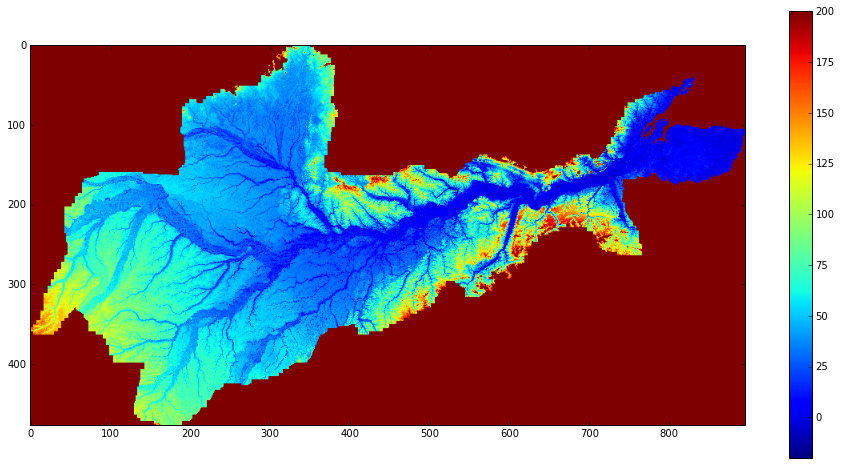

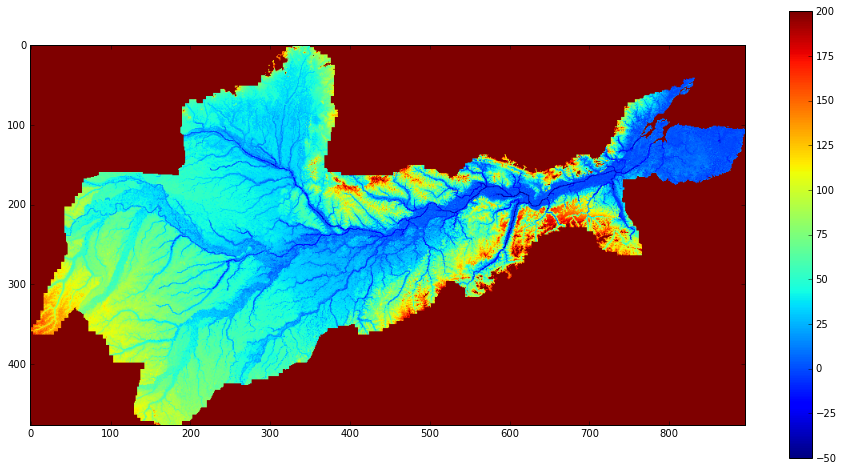

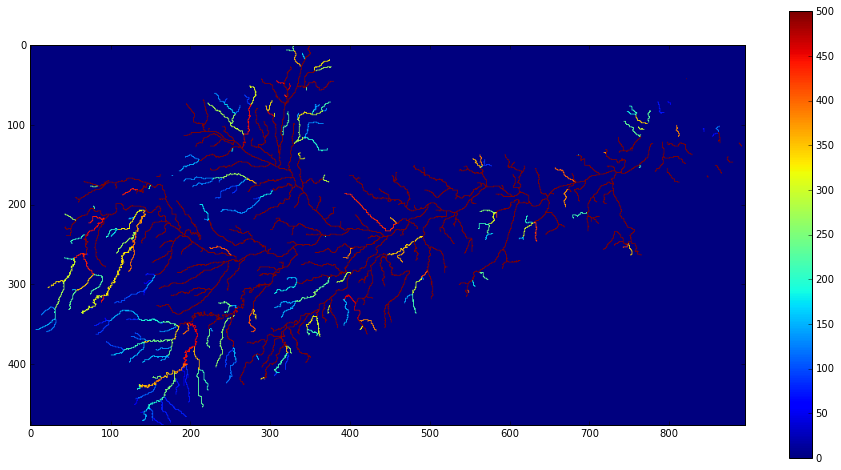

In [10]:
if model_type == 'LFP':
    plt.figure(figsize=(16,8))
    plt.imshow(DEM, vmax=200)
    plt.colorbar()
    plt.figure(figsize=(16,8))
    plt.imshow(SGCz, vmax=200)
    plt.colorbar()
    plt.figure(figsize=(16,8))
    plt.imshow(SGCwidth, vmax=500)
    plt.colorbar()

In [11]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [12]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                  hydrodynamic_coords_1D, 
                                                                                                  verbose)

print len(hydrodynamic_coords_1D)
print len(couple_HDYN_2_HLOG)

# linking PCR-cells with 2D hydrodynamic cells
couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                                 hydrodynamic_coords_2D, 
                                                                                                                 verbose)

print len(hydrodynamic_coords_2D)
print len(couple_HDYN_2_HLOG_2way)

17108
17108
157874
157874


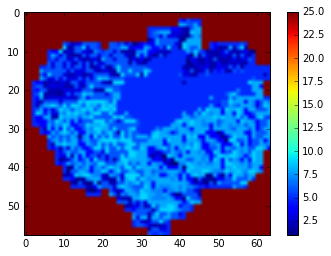

In [13]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
# -------------------------------------------------------------------------------------------------

newLDD = model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(newLDD)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

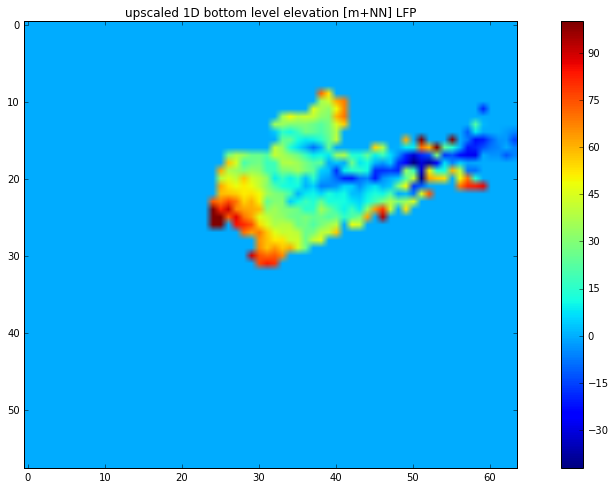

In [14]:
if model_type == 'LFP':
    bottom_lvl_1d = SGCz[i_1d,j_1d]
    bottom_lvl_2d = SGCz[i_2d,j_2d]

bottomElevation_HDYN1D_2_HLOG_BMI = model_functions.determine_bottomElev1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                         coupled_HLOG_indices,
                                                                                         bottom_lvl_1d,
                                                                                         landmask_pcr)

plt.figure(figsize=(16,8))
plt.title('upscaled 1D bottom level elevation [m+NN] ' + str(model_type))
plt.imshow(bottomElevation_HDYN1D_2_HLOG_BMI, vmax=100)
plt.colorbar()

In [15]:
if model_type == 'DFM':
    current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
    current_water_depth_1D = current_water_depth[separator_1D:]
    current_water_depth_2D = current_water_depth[:separator_1D]
elif model_type == 'LFP':
    current_water_depth = np.copy(hydrodynamicModel.get_var('H'))
    current_water_depth_1D = current_water_depth[i_1d,j_1d]
    current_water_depth_2D = current_water_depth[i_2d,j_2d]
    cellAreaSpherical_1D = cellArea[i_1d,j_1d]
    cellAreaSpherical_2D = cellArea[i_2d,j_2d]

In [16]:
inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

In [17]:
inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

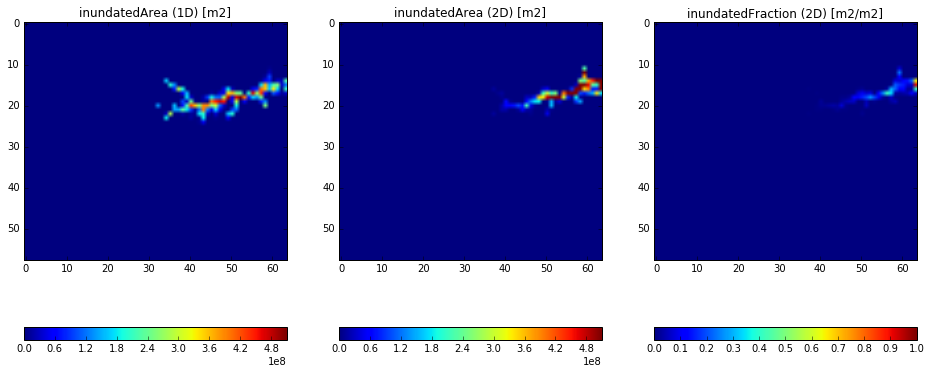

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI, vmax=np.max(inundatedArea_HDYN1D_2_HLOG_BMI))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedAreaAndFraction_HDYN_2_HLOG_BMI.png'), dpi=300)

In [19]:
if model_type == 'DFM':
    current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
    current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
    current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells
elif model_type == 'LFP':
    current_water_volume = cellArea * hydrodynamicModel.get_var('H')
    current_water_volume_1D = current_water_volume[i_1d, j_1d]
    current_water_volume_2D = current_water_volume[i_2d, j_2d]

In [20]:
waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

In [21]:
waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

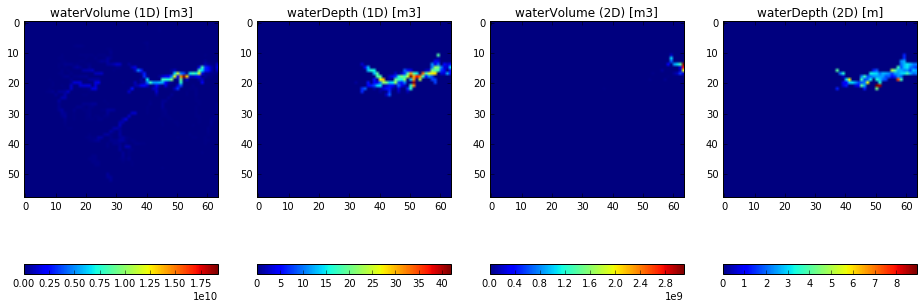

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [23]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

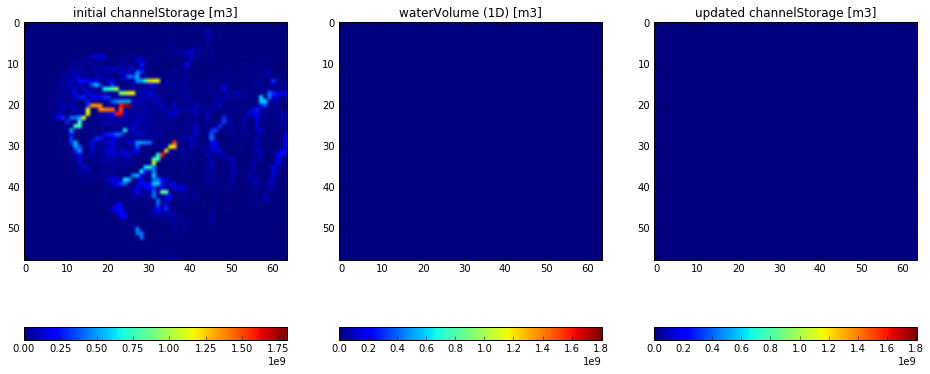

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [25]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 8.94374106056


In [26]:
hydrologicModel.update(1)

2018-03-01 15:46:30,482 model.pcrglobwb INFO Reading forcings for time 1984-01-01
2018-03-01 15:46:31,318 model.pcrglobwb INFO Updating model for time 1984-01-01
2018-03-01 15:46:31,619 model.landSurface INFO Updating land cover: forest
2018-03-01 15:46:31,622 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-03-01 15:46:31,896 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-03-01 15:46:32,167 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: cov

In [27]:
#waterVolume_HDYN2D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 4.15E+10
feedback volume from FM: 1.52E+10 
delta volume of all PCR cells after feedback from DFM: 2.64E+10
reduction by  36.52 %
delta volume for PCR cells coupled to hydrodynamic channels 1.34E+10


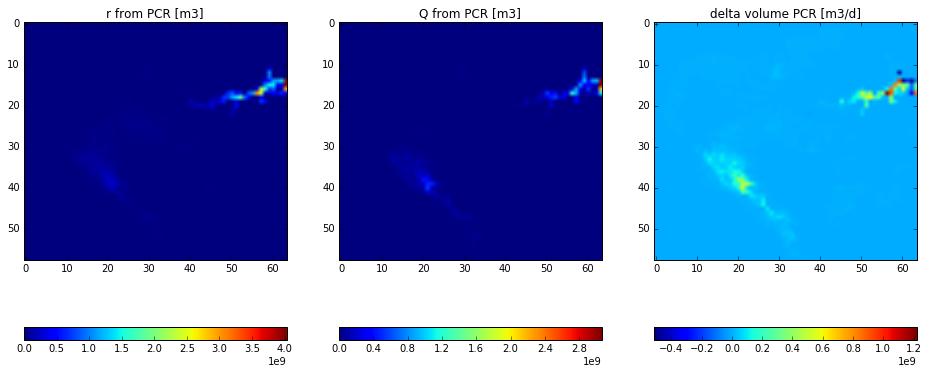

In [28]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = -999
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = -999

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [29]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [30]:
if model_type == 'LFP':
    
    delta_water_DFM_1way = model_functions.fillLFPgrid(hydrodynamicModel, 
                                                       coupledFPindices_1way, 
                                                       delta_water_DFM_1way, 
                                                       DEM, 
                                                       verbose_folder, 
                                                       verbose=False)
    
    model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose=False)

In [31]:
while hydrodynamicModel.get_current_time() < (hydrologicModel.get_time_step() * secPerDay):
    
    if model_type == 'LFP':
        hydrodynamicModel.update()
        
    elif model_type == 'DFM':
        model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose)

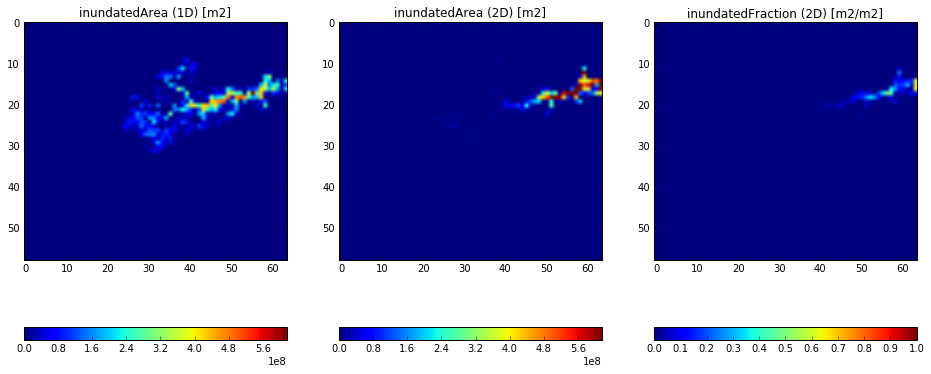

In [104]:
if model_type == 'DFM':
    current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
    current_water_depth_1D = current_water_depth[separator_1D:]
    current_water_depth_2D = current_water_depth[:separator_1D]
elif model_type == 'LFP':
    current_water_depth = np.copy(hydrodynamicModel.get_var('H'))
    current_water_depth_1D = current_water_depth[i_1d,j_1d]
    current_water_depth_2D = current_water_depth[i_2d,j_2d]
    cellAreaSpherical_1D = cellArea[i_1d,j_1d]
    cellAreaSpherical_2D = cellArea[i_2d,j_2d]

inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI, vmax=np.max(inundatedArea_HDYN1D_2_HLOG_BMI))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

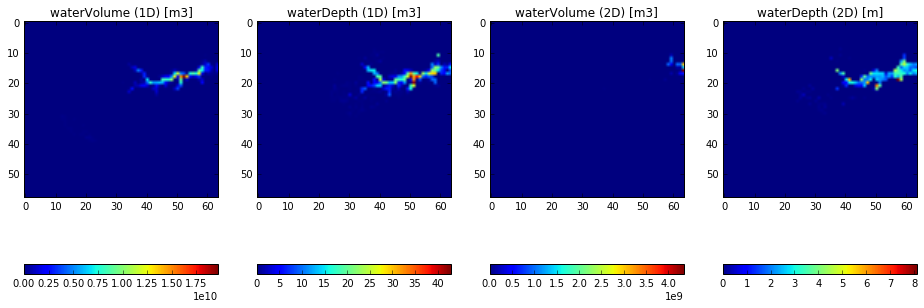

In [105]:
if model_type == 'DFM':
    current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
    current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
    current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells
elif model_type == 'LFP':
    current_water_volume = cellArea * hydrodynamicModel.get_var('H')
    current_water_volume_1D = current_water_volume[i_1d, j_1d]
    current_water_volume_2D = current_water_volume[i_2d, j_2d]

waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
# plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

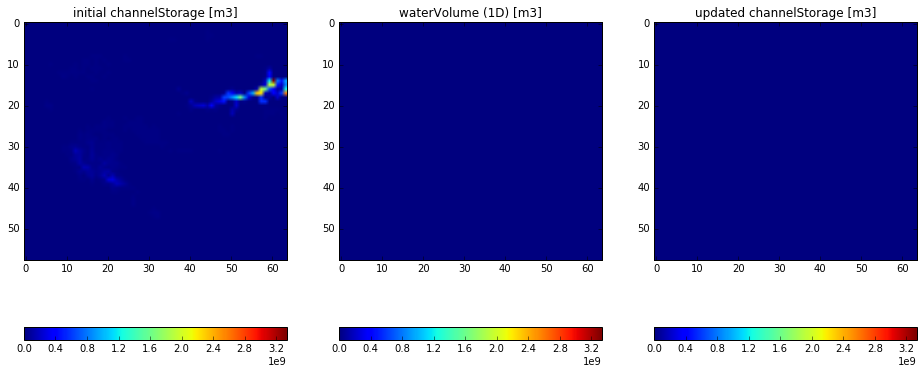

In [106]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [107]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 8.106512385


In [108]:
model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

hydrologicModel.update(1)

2018-03-01 15:53:29,440 model.pcrglobwb INFO Reading forcings for time 1984-01-08
2018-03-01 15:53:32,166 model.pcrglobwb INFO Updating model for time 1984-01-08
2018-03-01 15:53:32,175 model.landSurface INFO Updating land cover: forest
2018-03-01 15:53:32,181 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-03-01 15:53:32,980 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-03-01 15:53:33,881 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: cov

In [109]:
#TODO: this function needs to be extended to account for negative delta volumes!
delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 4.95E+10
feedback volume from FM: 1.63E+10 
delta volume of all PCR cells after feedback from DFM: 3.32E+10
reduction by  32.99 %
delta volume for PCR cells coupled to hydrodynamic channels 2.80E+10


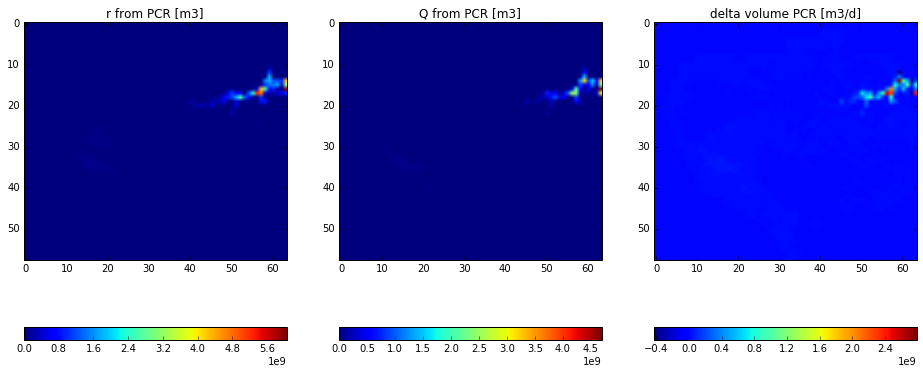

In [110]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = 0.
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = 0.

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [111]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [112]:
if model_type == 'LFP':
    
    delta_water_DFM_1way = model_functions.fillLFPgrid(hydrodynamicModel, 
                                                       coupledFPindices_1way, 
                                                       delta_water_DFM_1way, 
                                                       DEM, 
                                                       verbose_folder, 
                                                       verbose=False)
    
    model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose=False)

In [113]:
while hydrodynamicModel.get_current_time() < (hydrologicModel.get_time_step() * secPerDay):
    
    if model_type == 'LFP':
        hydrodynamicModel.update()
        
    elif model_type == 'DFM':
        model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose)

In [114]:
execute_all = False

In [115]:
if execute_all == True:

    while hydrologicModel.get_time_step() < end_time_pcr:

        current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
        current_water_depth_1D = current_water_depth[separator_1D:]
        current_water_depth_2D = current_water_depth[:separator_1D]

        inundatedArea_HDYN1D_2_HLOG, \
            inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                                       coupled_HLOG_indices,
                                                                                                       current_water_depth_1D,
                                                                                                       threshold_inundated_depth,
                                                                                                       cellAreaSpherical_1D,
                                                                                                       landmask_pcr)

        inundatedArea_HDYN2D_2_HLOG, \
            inundatedArea_HDYN2D_2_HLOG_BMI, \
                inundatedFraction_HDYN2D_2_HLOG, \
                    inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                                   coupled_HLOG_indices_2way,
                                                                                                                   current_water_depth_2D,
                                                                                                                   threshold_inundated_depth,
                                                                                                                   cellAreaSpherical_2D,
                                                                                                                   cellarea_data_pcr,
                                                                                                                   landmask_pcr)

        current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
        current_water_volume_1D = current_water_volume[separator_1D:]
        current_water_volume_2D = current_water_volume[:separator_1D]

        waterVolume_HDYN1D_2_HLOG,\
            waterVolume_HDYN1D_2_HLOG_BMI,\
                waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                                  inundatedArea_HDYN1D_2_HLOG,
                                                                                                  current_water_volume_1D,
                                                                                                  couple_HLOG_2_HDYN,
                                                                                                  coupled_HLOG_indices, 
                                                                                                  landmask_pcr)

        waterVolume_HDYN2D_2_HLOG_BMI,\
            waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                              inundatedArea_HDYN2D_2_HLOG,
                                                                                              waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                              couple_HLOG_2_HDYN_2way,
                                                                                              coupled_HLOG_indices_2way,
                                                                                              landmask_pcr)

        ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

        if couple_channelStorage == False:
            waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

        model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

        model_functions.updateHydrologicVariables(hydrologicModel,
                                                  waterDepth_HDYN2D_2_HLOG_BMI,
                                                  inundatedFraction_HDYN2D_2_HLOG_BMI)

        model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

        hydrologicModel.update(1)

        delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                        missing_value_pcr, 
                                                                                        secPerDay, 
                                                                                        coupled_HLOG_indices, 
                                                                                        cellarea_data_pcr, 
                                                                                        waterVolume_HDYN2D_2_HLOG_BMI)

        delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                            couple_HDYN_2_HLOG, 
                                                                                            couple_HLOG_2_HDYN,
                                                                                            coupled_HLOG_indices,
                                                                                            delta_volume_PCR_1way, 
                                                                                            cellAreaSpherical_1D, 
                                                                                            fraction_timestep, 
                                                                                            model_type, 
                                                                                            use_Fluxes)

        model_functions.updateModel(hydrodynamicModel, 
                                    delta_water_DFM_1way, 
                                    update_step, 
                                    separator_1D, 
                                    use_Fluxes, 
                                    use_RFS, 
                                    model_type, 
                                    verbose)


    hydrodynamicModel.finalize()
    hydrologicModel.finalize()